In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from matplotlib import cm


### Lecture 25:

- Learn about 3D plots of points and surfaces
- Show some examples with subduction zone Earthquakes and isotopic systems




### 3D Plotting with Python

Contour plots are really just a way to visualize something that is inherently 3D on a 2D surface.  Think about our topographic map - the contour intervals are elevations and our brains can reconstruct the 3D world by looking at the contours on the map.  But with computers we can visualize the 3D world in a more realistic manner.  There are many 3D plotting packages that apply many different approaches to plot in 3D.  For example,  **mplot3d**, is a 3D toolkit of **matplotlib** that uses the same logic as for "regular"  **matplotlib**. For more on this module, see:

http://matplotlib.sourceforge.net/mpl_toolkits/mplot3d/index.html


 But for more 3D horsepower, there is a module called **mlab**, which is part of the **mayavi** package.  See: 
 
 
 http://github.enthought.com/mayavi/mayavi/mlab.html


 And then there is **Mayavi** itself, which comes with the Canopy Python Edition.   This was way beyond what I know, but if you are curious, check out this website:
 
 http://github.enthought.com/mayavi/mayavi/examples.html
 

### 3D Plotting in Jupyter Notebooks
Until now, we have used **%matplotlib inline** to plot our matplotlib figures within the jupyter notebook.  In order to plot a 3D figure within the jupyter notebook and allow interaction with a 3D plot, we must use this alternative:  **%matplotlib notebook**

## Plotting points in 3D

Remember this plot from Lecture 18?

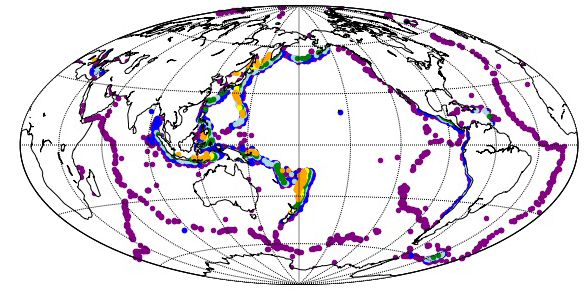

In [2]:
Image(filename='Figures/earthquakes_depth.png')

We used color to represent the depth of each earthquake . You can see that there are increasingly deep earthquakes as you move away from subduction zones- sort of.  

It would be more instructive to view the depth of the earthquakes as points in a 3D plot.   So, let's read-in the data, filter for a lat/lon box from 35$^{\circ}$S to 20$^{\circ}$N and 170$^{\circ}$-190$^{\circ}$E (the Marianas trench), and plot the data in 3D.

To begin, let's filter the data by the desired bounds and make an array of longitudes,x, an array of latitudes,y,and an array of depths,z.  

In [3]:
# read in the data from the Lecture 18 as a Pandas DataFrame: 
eq_data=pd.read_csv('Datasets/EarthquakeLocations/last5Years.csv',skiprows=1)

# define some boundaries for our box
lat_min,lon_min,lat_max,lon_max=-35,175,-15,190

# use Pandas filtering to fish out lat/lon in this range
box=eq_data[(eq_data.longitude.values%360<lon_max)&(eq_data.longitude.values%360>=lon_min)] 
box=box[(box.latitude.values<lat_max)&(box.latitude.values>=lat_min)] 

# and export them to NumPy arrays
x=box.longitude.values%360
y=box.latitude.values
z=-box.depth.values


We can use the **Axes3D** class from the **mplot3d**, which is another tool in the **matplotlib** toolkit (**mpl_toolkits**). [Remember that is where we got Basemap.] 

We will import the **Axes3D** module.  

But before we can use it, we have to make the notebook ready for 3D plots.  One somewhat annoying thing about using the 3D options in a Jupyter notebook is that there are two different **magic** commands that are used.  You are already familiar with the **%matplotlib inline** command that allows us to plot "regular" matplotlib plots in the notebook. But now we need a NEW one:  **%matplotlib notebook** strictly for plotting 3D objects.  The trouble comes when you try to do both in one notebook, because you have to always use the magic correct command before you can see your figure.  So we import the Axes3D module and call the magic command:

%matplotlib notebook

In [2]:
# import the module
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


The trick to using **Axes3D** is to first make a figure object using **plt.figure( )** (called  **fig** below) and then  use the figure method **fig.add_subplot( )**  to make an **Axis** instance (here called **ax**).   Finally we set the keyword **projection**  of the **add_sublot** call to '3d'.   

<IPython.core.display.Javascript object>


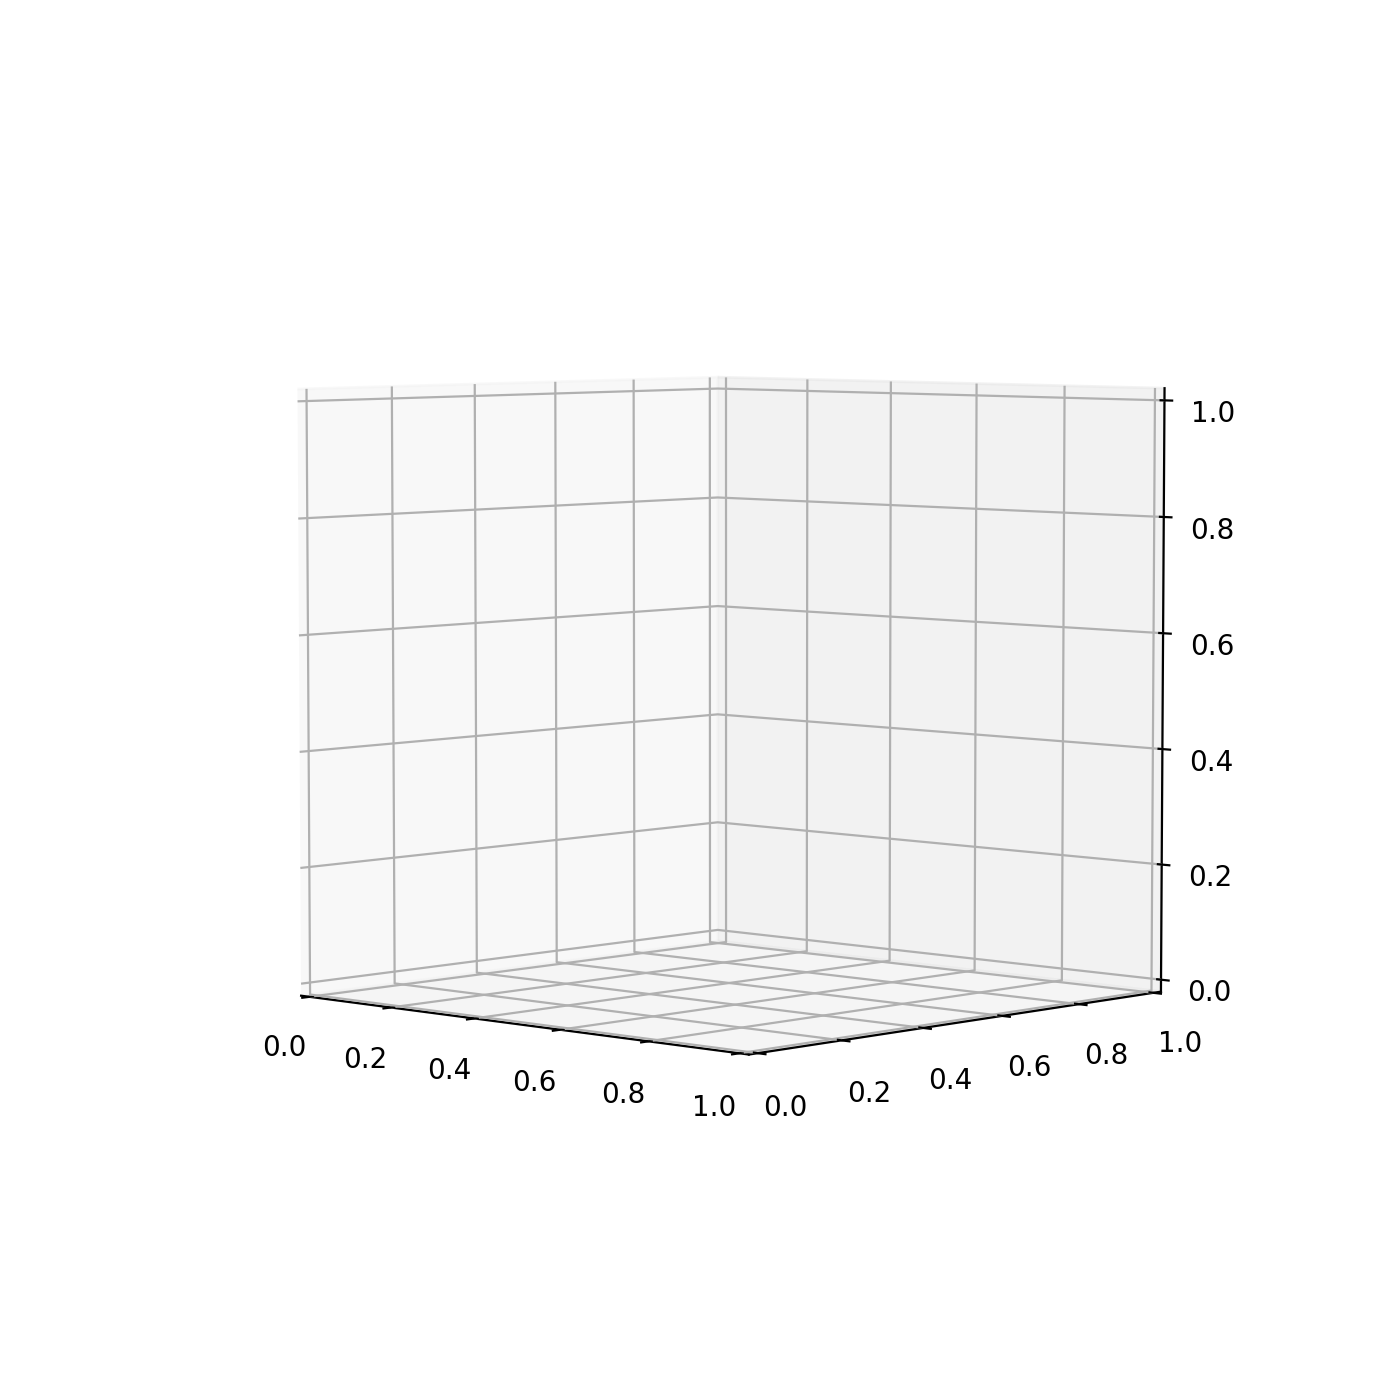

In [3]:
fig=plt.figure(1,(7,7)) # we need to make a figure object
ax = fig.add_subplot(111, projection='3d'); # so we can do this.  

This makes an empty set of axes.   But you can twirl them around!  [Okay, I thought that was cool.]  


Now we can decorate the plot with some data.  

<IPython.core.display.Javascript object>


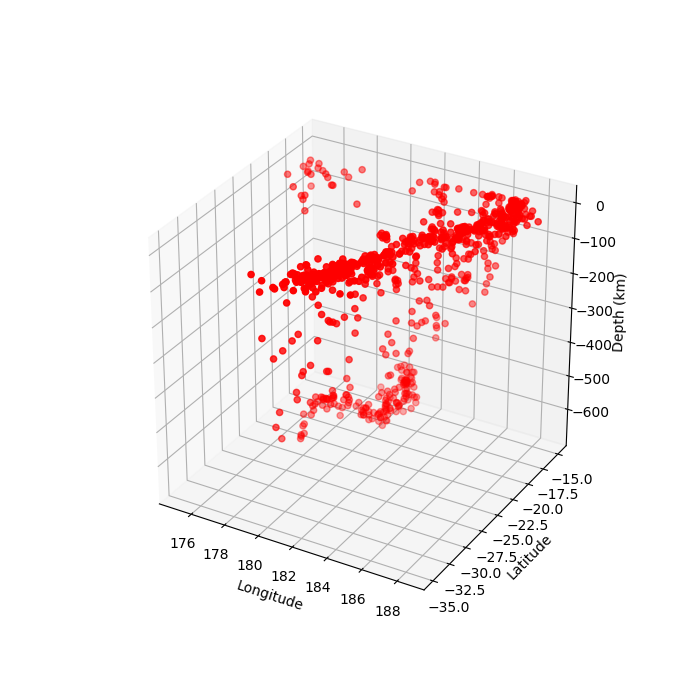

In [6]:
fig=plt.figure(2,(7,7)) # let's make a new one.
ax = fig.add_subplot(111, projection='3d') # so we can do this.  


ax.scatter(x,y,z,c='r',marker='o')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)');

Try twirling the figure around!  Can you see the slab?  

You can imagine other enhancements, for example setting the size of the points to be proportional to the size of the earthquake.

### 3D contour type plots

In Lecture 19, we learned how to make 2D color contour plots, but 3D is much more fun, so let's try to make a 3D version of something geophysical, namely the gravity anomaly of a buried sphere. 

Let's choose a sphere with a radius $R$ of 2 m (whose volume is ${{4\pi}\over{3}}R^3$), that is buried $z=$ 3 m deep.  The sphere's density ($\Delta \rho$) is 500 kg/m$^3$, which is, for this purpose, much higher than the surrounding material.    Oh and we'll need the universal gravitational constant $G$, which is  6.67x 10$^{-11}$ Nm$^2$/kg$^2$.

The formula for gravitational attraction of such a body is: 

$$g= {{4\pi}\over{3}} R^3 {{G   \Delta \rho}\over{(h^2+z^2})},$$

where $h$ is the horizontal distance from the mass.

The units (from dimensional analysis remembering that Newtons are kg $\cdot$ m $\cdot$ s$^2$) are m $\cdot$ s$^{-2}$.  1 Gal (for Galileo) = 1 cm $\cdot$s$^{-2}$, so to convert $g$ to the units of microgals, we multiply the above by 10$^{8}$.  

We can write our equation as a lambda function.

In [7]:
gravity= lambda G,R,drho,h,z : (1e8*G*4.*np.pi*R**3.*drho)/(3.*(h**2+z**2)) # gravitational attraction. 

And set up the arrays the same way as we did in the previous lectures as a color contour on a 2D surface. 




In [8]:
x=np.arange(-6.,6.,0.1) # range of x values
y=np.arange(-6,6.,0.1) # range of y values
X,Y=np.meshgrid(x,y) # make a meshgrid

To get the gravity array $g$, we need $z,G,R$ and $\Delta \rho$ and $h$ the horizontal distance from ground zero of the buried sphere, which is given by good old Pythagorous as: 

$$ h=\sqrt {x^2 + y^2}. $$  



In [9]:
# define the other parameters
z=3.
G=6.67e-11 # grav constant in Nm^2/kg^2 (SI)
R=2. # radius in meters
drho=500 # density contrast in kg/m^3

h=np.sqrt(X**2+Y**2) # get the horizontal distance from ground zero for x,y
# and make the g array
g=gravity(G,R,drho,h,z) # multipy by a million to get the units reasonable for the plots.

We want to make the plot of the gravitational attraction first using our old friend from the Lecture 19, **plt.pcolormesh( )**. 

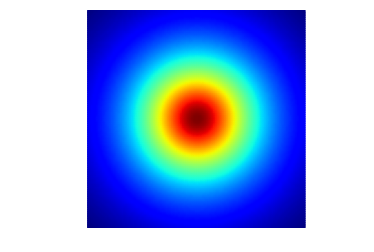

In [10]:
# put this back to 'normal' for use in the notebook using the correct Jupyter magic command 
%matplotlib inline 
plt.figure(3)
plt.pcolormesh(x,y,g,cmap=cm.jet,shading='gouraud')
plt.axis('equal')
plt.axis('off');

Well that IS pretty.  But now we want to do this in 3D.

### 3D Surfaces

There are a few ways to  plot this in 3D: wireframes and surfaces.  Let's start with a wireframe plot.  For this we need to  use matplotlib **Axes3D**.  

#### Wireframes
There is an **Axes3D** method called **plot_wireframe( )** which will do the trick. It is in many ways similar to the **pcolormesh( )**, but instead of using color to represent values, it uses a 3D projection.   
Let's try the **plot_wireframe( )** function on our gravity data.  

 In the following plot, we  create an **Axes3D** instance called **ax**  from the **figure** object,  **fig**.  By setting $projection='3d'$, we get a 3D projection.  

Remember that because we were just plotting in 2D (%matplotlib inline), we have to call the 3D version (%matplotlib notebook).   


<IPython.core.display.Javascript object>


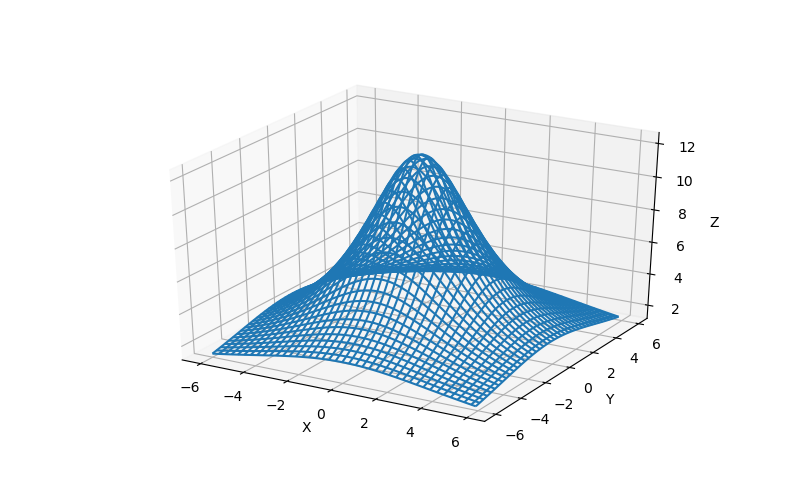

In [26]:
# makes a 3D plot in a notebook
%matplotlib notebook  
fig=plt.figure(4,(8,5)) # make a figure object
ax=fig.add_subplot(111,projection='3d') # give it the powers of an Axes3D object
surf=ax.plot_wireframe(X,Y,g) # use plot_wireframe to do the plot.
ax.set_xlabel('X') # and label the axes
ax.set_ylabel('Y')
ax.set_zlabel('Z');


Try twirling it around - pretty cool, huh?  

#### surfaces

There is a related  method **plot_surface( )** which is also nice.  We then call **plot_surface( )** on the **Axes3D** instance and set labels to the 3 axis. Note that if we assign the surface instance to a variable, e.g., **surf**, we can do other things to it, like add a color bar.  Finally, please admire the use of a colormap  (**cmap=cm.rainbow**).


This works pretty much like **plot_wireframe( )** but this one we can put a color bar on too.



<IPython.core.display.Javascript object>


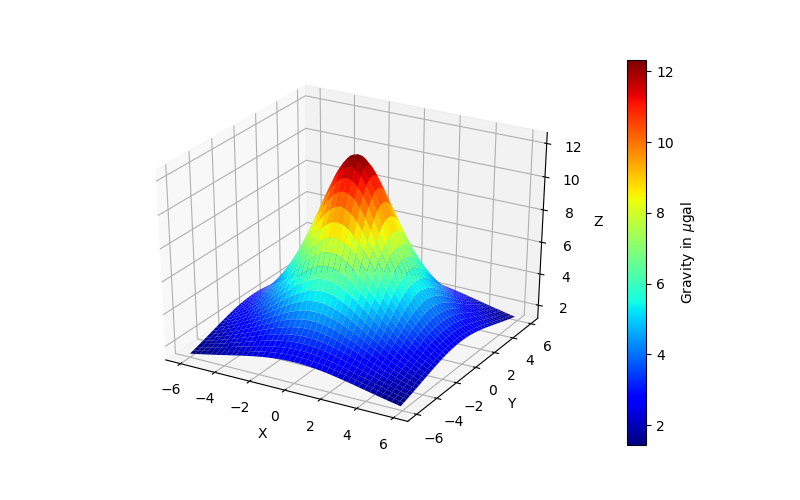

In [27]:
 # make the notebook ready for interactive 3D plots again
%matplotlib notebook 
fig=plt.figure(4,(8,5)) # make a figure object
ax=fig.add_subplot(111,projection='3d') # get a 3d plot object
surf=ax.plot_surface(X,Y,g,cmap=cm.jet) # use plot_surface to do the plot using a color map
ax.set_xlabel('X') # and label the axes
ax.set_ylabel('Y')
ax.set_zlabel('Z')
bar=fig.colorbar(surf) # put on the color bar
bar.set_label('Gravity in $\mu$gal'); #label the color bar

OR - we can plot the data as a 3D color contour plot.  For this, we can use **ax.contour( )**.  

<IPython.core.display.Javascript object>


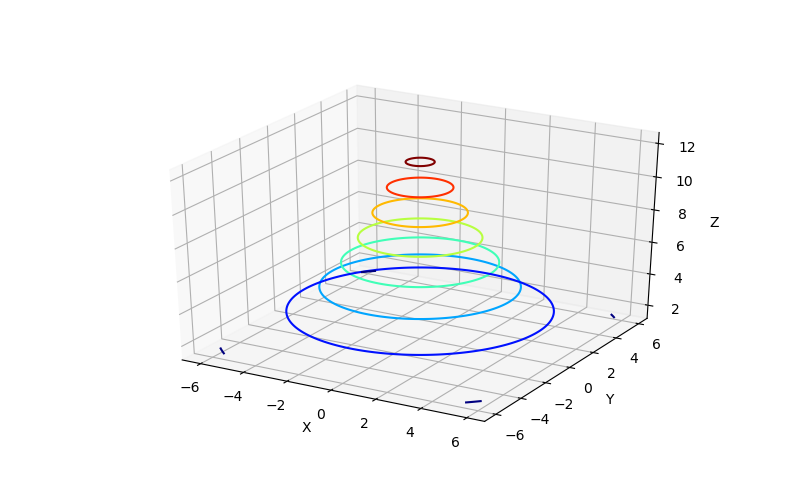

In [28]:
%matplotlib notebook 
fig=plt.figure(5,(8,5)) # make a figure object
ax=fig.add_subplot(111,projection='3d') # give it the powers of an Axes3D object
surf=ax.contour(X,Y,g,cmap=cm.jet) # use contour to do the plot using a color map
ax.set_xlabel('X') # and label the axes
ax.set_ylabel('Y')
ax.set_zlabel('Z');

We can even make a wedding cake setting the **extend3d** keyword of the **ax.contour( )** function to **True**. 

<IPython.core.display.Javascript object>


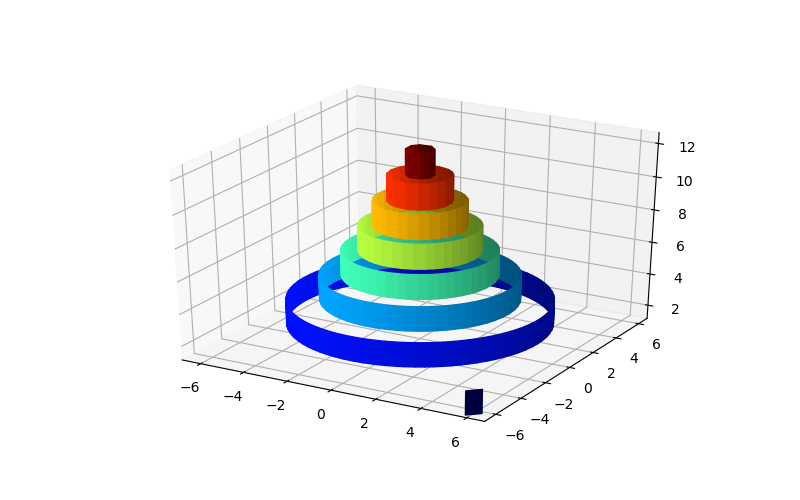

In [29]:
%matplotlib notebook 
fig=plt.figure(5,(8,5)) # make a figure object
ax=fig.add_subplot(111,projection='3d') # give it the powers of an Axes3D object
surf=ax.contour(X,Y,g,extend3d=True,cmap=cm.jet) # use contour to do the plot using a color map


Or to really get into it, we can plot contours onto projected planes using the **ax.contour( )** method.  The keyword **offset** sets where eacj plane will be put and the **zdir** keyword says which axis to project.   You just have to play with this a while, to see how it works.  

<IPython.core.display.Javascript object>


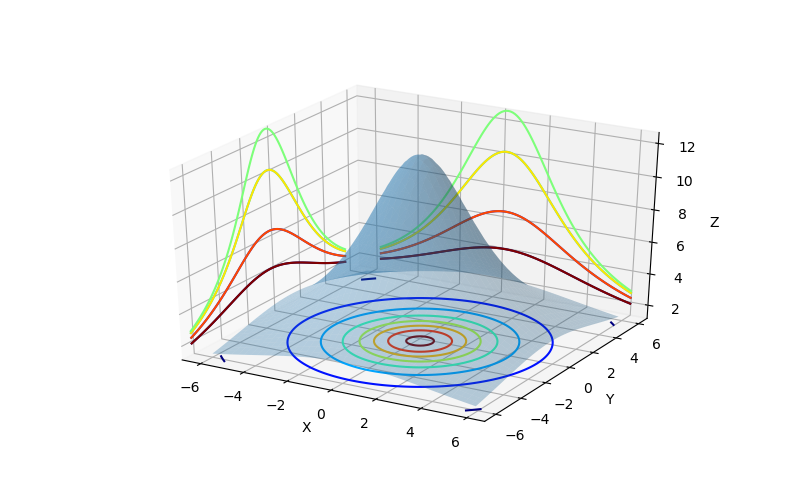

In [30]:
fig=plt.figure(6,(8,5)) # make a figure object
ax=fig.add_subplot(111,projection='3d') # give it the powers of an Axes3D object
surf=ax.plot_surface(X,Y,g,alpha=0.3) 
cset=ax.contour(X,Y,g,zdir='z',offset=1,cmap=cm.jet)
cset=ax.contour(X,Y,g,zdir='x',offset=-7,cmap=cm.jet)
cset=ax.contour(X,Y,g,zdir='y',offset=7,cmap=cm.jet)
ax.set_xlabel('X') # and label the axes
ax.set_ylabel('Y')
ax.set_zlabel('Z');

### Plotting vectors

Before we leave the gravity anomaly problem, consider one more way to plot the data.  Gravity data are inherently vectors, so we could plot them as arrows.  This can be done  using the **plt.quiver( )** method.





In [18]:
help(plt.quiver)

Help on function quiver in module matplotlib.pyplot:

quiver(*args, **kw)
    Plot a 2-D field of arrows.
    
    Call signatures::
    
      quiver(U, V, **kw)
      quiver(U, V, C, **kw)
      quiver(X, Y, U, V, **kw)
      quiver(X, Y, U, V, C, **kw)
    
    *U* and *V* are the arrow data, *X* and *Y* set the location of the
    arrows, and *C* sets the color of the arrows. These arguments may be 1-D or
    2-D arrays or sequences.
    
    If *X* and *Y* are absent, they will be generated as a uniform grid.
    If *U* and *V* are 2-D arrays and *X* and *Y* are 1-D, and if ``len(X)`` and
    ``len(Y)`` match the column and row dimensions of *U*, then *X* and *Y* will be
    expanded with :func:`numpy.meshgrid`.
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* kwargs.
    
    The defaults give a slightly swept-back arrow; to make the head a
    triangle, make *headaxislength* the

So we need the x,y coordinates of the gravity vector and plot the arrows
at the evaluation points. 

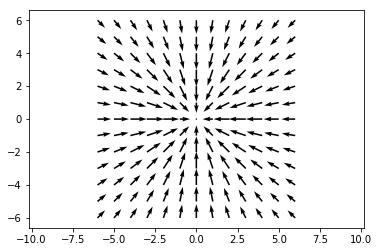

In [19]:
# we need to  redo what we already did.  but at lower resolution
%matplotlib inline
z=3.
G=6.67e-11 # grav constant in Nm^2/kg^2 (SI)
R=2. # radius in meters
drho=500 # density contrast in kg/m^3

h=np.sqrt(X**2+Y**2) # get the horizontal distance from ground zero for x,y
# and make the g array
g=gravity(G,R,drho,h,z) # multipy by a million to get the units reasonable for the plots.

x=np.arange(-6,6.5,1) # range of x values
y=np.arange(-6.,6.5,1) # range of y values
X,Y=np.meshgrid(x,y) # make a meshgrid
h=np.sqrt(X**2+Y**2) # get the horizontal distance from ground zero for x,y
g=gravity(G,R,drho,h,z) # re-use our lambda function

#  now make the horizontal projections along X and Y
U=-X*g
V=-Y*g
# and plot
plt.quiver(x,y,U,V)
plt.axis('equal');

Let's return for a moment to the topic of Lecture 24 where we categorized isotopic data into different "principle componennts" using **sklearn**.    Now we can plot the different components on a 3D plot.  We can use a new trick to create a discrete color map based on an input map, too.  Here's a function **discrete_cmap** that does it: 

In [32]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return color_list

So we read in the data from Lecture 24 and split it into the PCAs as before

In [33]:
MantleArray=pd.read_csv('Datasets/GeoRoc/MantleArray_OIB.csv')
from sklearn.decomposition import PCA

X_PCA=np.array([MantleArray['EPSILON_ND'],MantleArray['SR87_SR86'],MantleArray['PB206_PB204'],\
                        MantleArray['EPSILON_HF']])
X_PCA=X_PCA.T

pca = PCA(3)
pca.fit(X_PCA)
Y_pca = pca.transform(X_PCA)

In [34]:
MantleArray['PCA_1']=Y_pca[:,0]
MantleArray['PCA_2']=Y_pca[:,1]
MantleArray['PCA_3']=Y_pca[:,2]

Now let's plot the end members in 3D! 

<IPython.core.display.Javascript object>


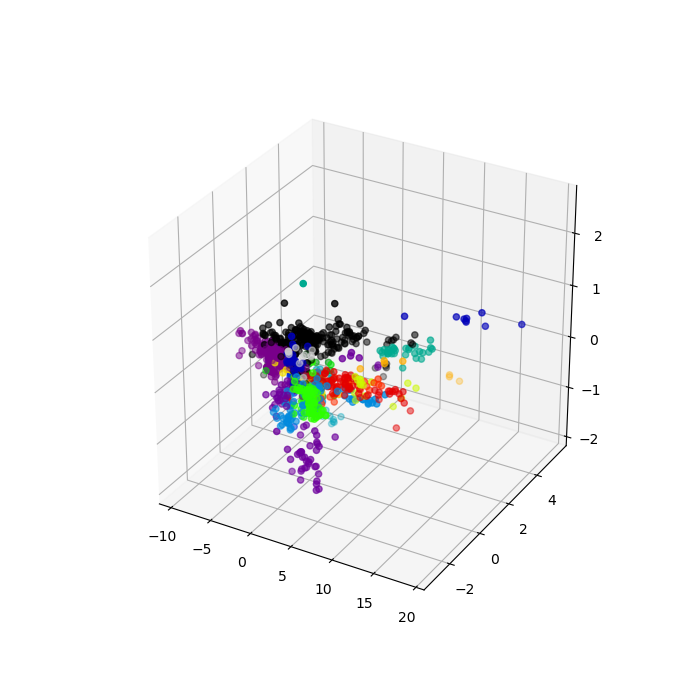

In [35]:
%matplotlib notebook
fig=plt.figure(2,(7,7)) # let's make a new one.
ax=fig.add_subplot(111,projection='3d') # so we can do this.  



locations=MantleArray['LOCATION'].unique() # get a list of unique locations
colors=discrete_cmap(len(locations),base_cmap='nipy_spectral') # get the color map
# assign the colors
MantleArray['COLOR']=[[0,0,0,0] for n in list(range(len(MantleArray)))]

# step through the locations and plot the data using the specified colors
for n in list(range(len(locations))):
    newslice=MantleArray.loc[MantleArray.LOCATION==locations[n],'COLOR']

    colorlist=pd.Series([colors[n] for m in list(range(len(newslice)))],index=newslice.index)
    MantleArray.loc[MantleArray.LOCATION==locations[n],'COLOR']=colorlist

ax.scatter(MantleArray['PCA_1'],MantleArray['PCA_2'],MantleArray['PCA_3'],c=MantleArray['COLOR'].values);

     

This lecture was just a sample of what is possible with 3D plotting.  Here are more examples that may inspire you.  Check out this website:  https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html  for  hints on how to do more.   

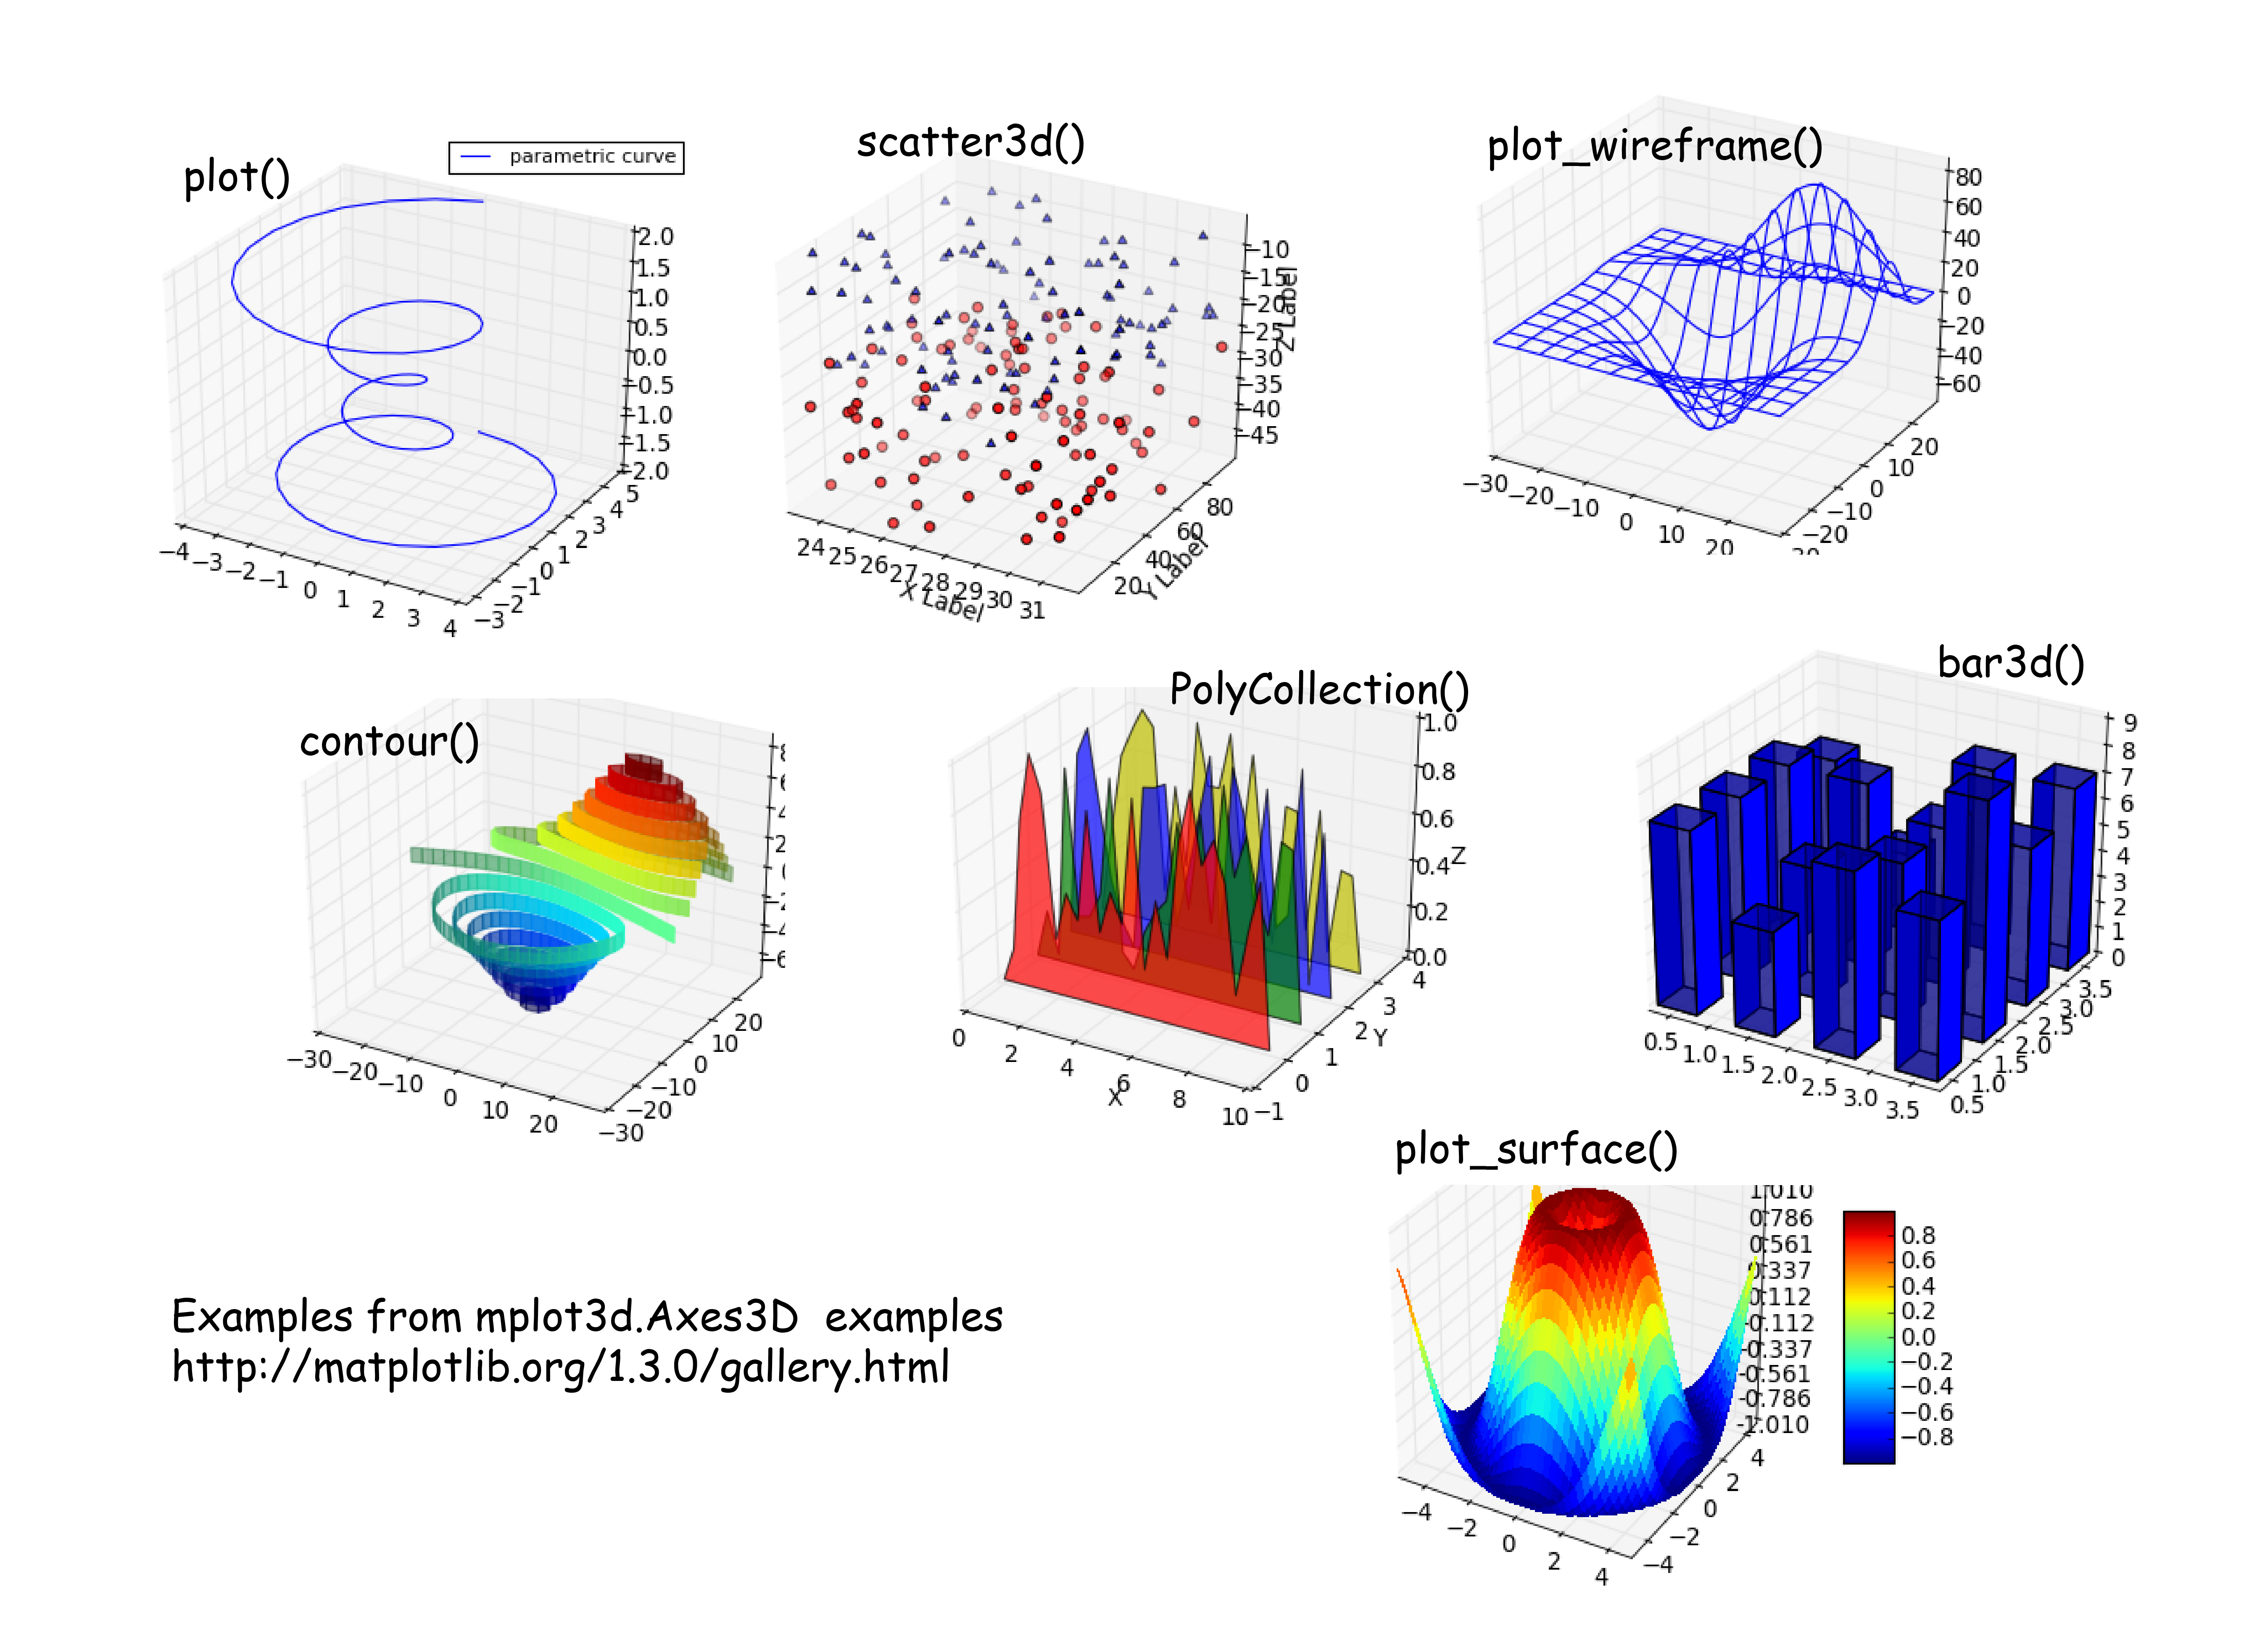

In [24]:
Image(filename='Figures/mplot3d-examples.png')

# Assignment 8


### 1.
- Read the dataset 'Datasets/woadata.csv' into a pandas DataFrame.
- This is a dataset containing normalized temperature, salinity, oxygen and nutrient data adapted from the NOAA World Ocean Atlas 2013 Vol 2 https://www.nodc.noaa.gov/OC5/woa13/
- Make an array containing all the data excluding the latitude, longitude and depth columns. Check that the shape is (2925,6)
- Perform a PCA in 1 dimension on your array. To do this you will need to import PCA, **fit** your pca to the data and then **transform** your data using the PCA.
- Make a 3D scatter plot of latitudes, longitudes and depths. Use the output of your PCA for the colors of the points.
- Label the axes.

### 2.
- Make another figure and plot the ocean data again. Now import the dataset from 'Datasets/topodata.csv' these are topography data for the california margin. These are topography data 
- Use **plot_surface** to plot latitudes,longitudes and elevation on the same axes. Hint: You will need to reshape the elevation data with **np.reshape()** and use **np.meshgrid( )** on the longitudes and latitudes.  We dealt with this kind of data in the topography dataset in Lecture 23. Color the surface grey.